In [1]:
%run header.py data/ASIC-2-FPGA

Python version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.20.1
matplotlib version: 2.0.2
NumPy version: 1.14.1
SciPy version: 1.0.0
IPython version: 5.3.0
scikit-learn version: 0.19.1
-------------------------


In [2]:
df = ML.fix_missing_data(gd.data_v4['adpcm_encoder'].drop(['index'], axis=1)[features])
X = df[valid_features].copy()
y = df.Slices.copy()
display(df.head(2))
display(X.head(2))
display(y.head(2))

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,0,0,0,0,0,21,0,0,394
1,1574,4,670,636,238,0,2935,1337,4,4,4.0,30,0,0,0,0,0,21,0,0,356


,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
0,1846,4,977,636,203,0,3246,1505,4,4,4.0,30,0,0,0,0,0,0,0
1,1574,4,670,636,238,0,2935,1337,4,4,4.0,30,0,0,0,0,0,0,0


0    394
1    356
Name: Slices, dtype: int64

# A Simple baseline approach: Removing features with low variance

 It removes all features whose variance does not meet some threshold.
 
 $$Var[X] = p(1-p)$$

In [25]:
p = 0.8
sel = feature_selection.VarianceThreshold(threshold=(p * (1 - p)))
X_fs = sel.fit_transform(X)

In [27]:
X.columns[sel.get_support()]

Index(['AREA', 'state', 'FU', 'REG', 'MUX', 'pin_pair', 'net', 'max', 'min',
       'ave', 'MISC'],
      dtype='object')

# Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests.

<http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py>

## Removes all but a user-specified highest scoring percentage of features

In [139]:
percentile = 50
sel = feature_selection.SelectPercentile(feature_selection.f_regression, percentile=percentile)
sel.fit(X, y)
# get scores
scores = sel.pvalues_.copy()
scores[np.isnan(scores)] = 1
scores = -np.log10(scores)
scores /= scores.max()
scores

C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


array([ 1.    ,  0.0194,  0.6658,  0.049 ,  0.1154, -0.    ,  0.7859,
        0.708 ,  0.0194,  0.0194,  0.0194,  0.0052, -0.    , -0.    ,
       -0.    , -0.    , -0.    , -0.    , -0.    ])

## Weights of an SVM

In [140]:
reg = svm.SVR(kernel='linear')
reg.fit(X, y)
# get weights
svm_weights = (reg.coef_ ** 2).sum(axis=0)
svm_weights /= svm_weights.max()
svm_weights

array([0.0468, 1.    , 0.0464, 0.0462, 0.0643, 0.    , 0.0041, 0.0081,
       1.    , 1.    , 1.    , 0.8106, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    ])

## Weights of an SVM after selection

In [141]:
reg.fit(sel.transform(X), y)
# get weights
svm_weights_selected = (reg.coef_ ** 2).sum(axis=0)
svm_weights_selected /= svm_weights_selected.max()
svm_weights_selected

array([0.0573, 1.    , 0.0319, 0.003 , 0.0662, 0.0723, 0.1935, 1.    ,
       1.    ])

## Visualization

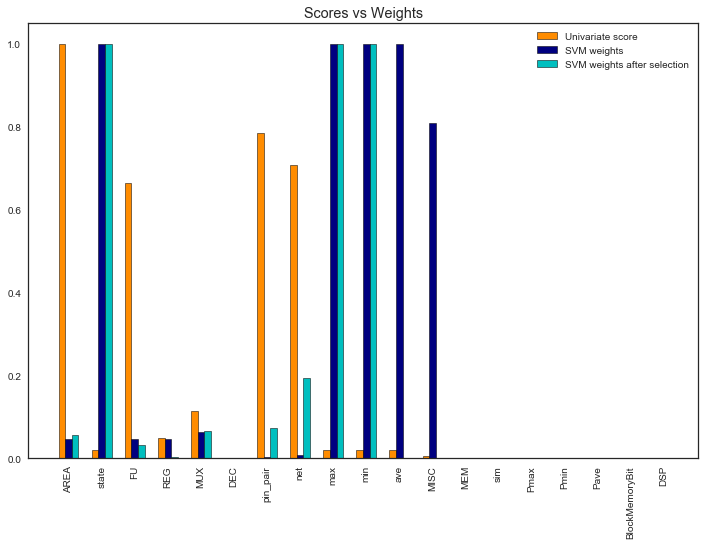

In [142]:
X_indiecs = np.arange(X.shape[-1])

plt.figure(1)
plt.clf()
w = 0.2

plt.bar(X_indiecs - w, scores, width=w, label='Univariate score', color='darkorange', edgecolor='black')
plt.bar(X_indiecs, svm_weights, width=w, label='SVM weights', color='navy', edgecolor='black')
plt.bar(X_indiecs[sel.get_support()] + w, svm_weights_selected, width=w, label='SVM weights after selection', color='c', edgecolor='black')

plt.xticks(X_indiecs, valid_features, rotation=90)
# plt.yticks(())
plt.legend(loc='best')
plt.title('Scores vs Weights')
plt.show()

# Comparison of F-test and mutual information

<http://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py>

F_test captures only linear dependency. <br />
Mutual information can capture any kind of dependency between variables.

In [82]:
f_test, _ = feature_selection.f_regression(X, y)
f_test = np.nan_to_num(f_test)
f_test /= np.max(f_test)

C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [83]:
mi = feature_selection.mutual_info_regression(X, y)
mi /= np.max(mi)

C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


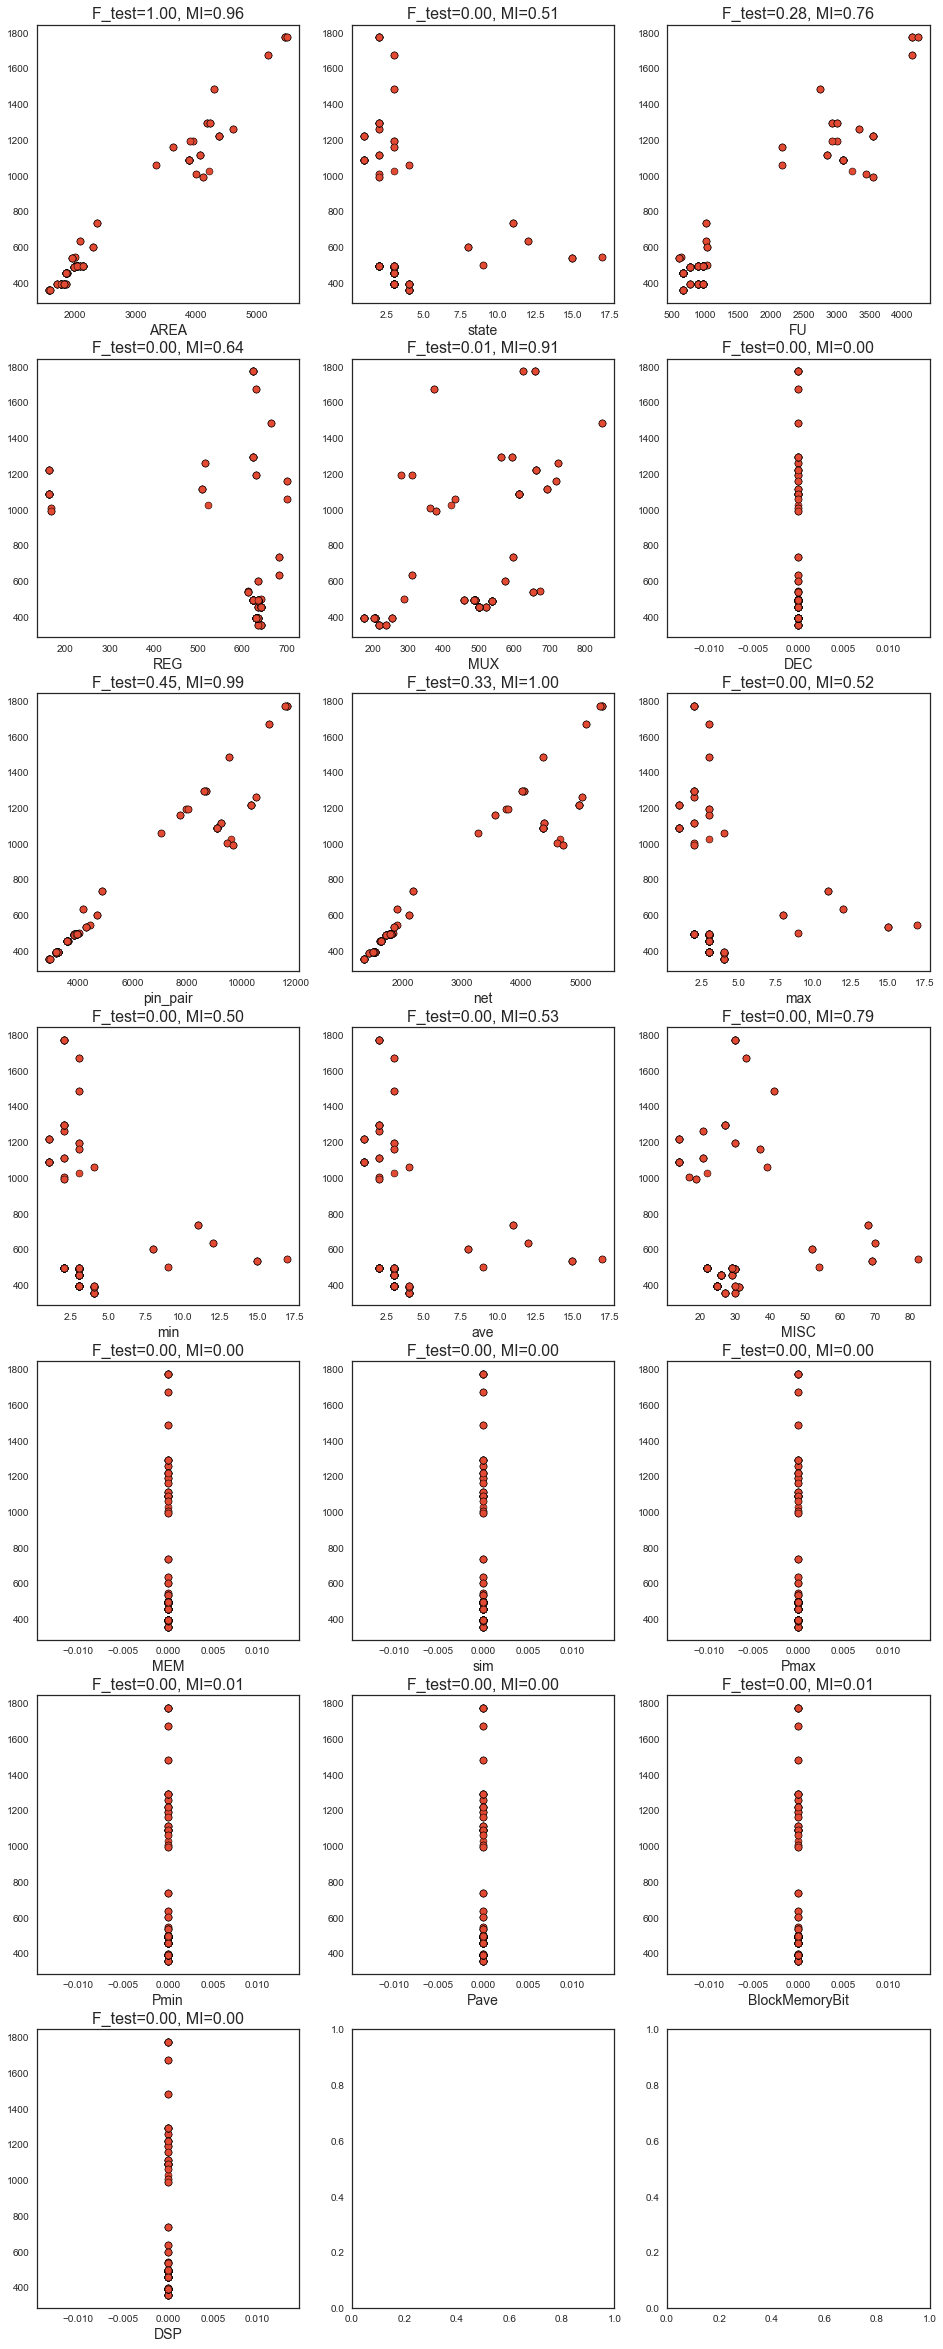

In [84]:
feature_cnt = len(valid_features)
ncol = 3
nrow = feature_cnt // ncol + 1 if feature_cnt % ncol else feature_cnt // ncol
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 6 * nrow))

for i in range(feature_cnt):
    if feature_cnt <= ncol:
        ax= axes[i]
    else:
        ax = axes[i // ncol, i % ncol]
    ax.scatter(X.values[:, i], y, edgecolor='black')
    ax.set_xlabel(valid_features[i], fontsize=14)
    ax.set_title('F_test={:.2f}, MI={:.2f}'.format(f_test[i], mi[i]), fontsize=16)
plt.show()

# Recursive feature elimination

An external estimator is trained on the initial set of features and the feature with least importance is pruned. This step is recursively repeated until the desired number of features is met.

The estimator must have the attribute of `coef_` or `feature_importances_`.

In [26]:
estimators_valid = {
    'LinReg': linear_model.LinearRegression(),
    'Lasso': linear_model.Lasso(),
    'ElasticNet': linear_model.ElasticNet(),
    'Ridge': linear_model.Ridge(),
    'SVR': svm.SVR(kernel='linear'),
    'LSVR': svm.LinearSVR(),
    'LinearSVR': svm.LinearSVR(random_state=42),
    'DecTreeReg': tree.DecisionTreeRegressor(random_state=42),
    'RF': ensemble.RandomForestRegressor(random_state=42),
    'AdaBoostDecTreeReg': ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), n_estimators=300),
    'GradBoostReg': ensemble.GradientBoostingRegressor(random_state=42),
}

In [27]:
estimator = estimators_valid['ElasticNet']  # the external estimator
n_features_to_select = 12  # the number of selected feature(s)
step = 1  # number of features to eliminate in every iteration

## Basic usage

<http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py>

In [179]:
rfe = feature_selection.RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=step)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(X.shape[-1])

In [180]:
ranking

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 4, 3, 2, 6, 7, 8])

## RFE with cross-validation

RFECV automatic tuning the number of features to be selected based on the cross-validation scores.

<http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py>

In [173]:
rfecv = feature_selection.RFECV(estimator=estimator, step=step, cv=model_selection.ShuffleSplit(), scoring='r2')
rfecv.fit(X, y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size='default',
       train_size=None),
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='r2', step=1, verbose=0)

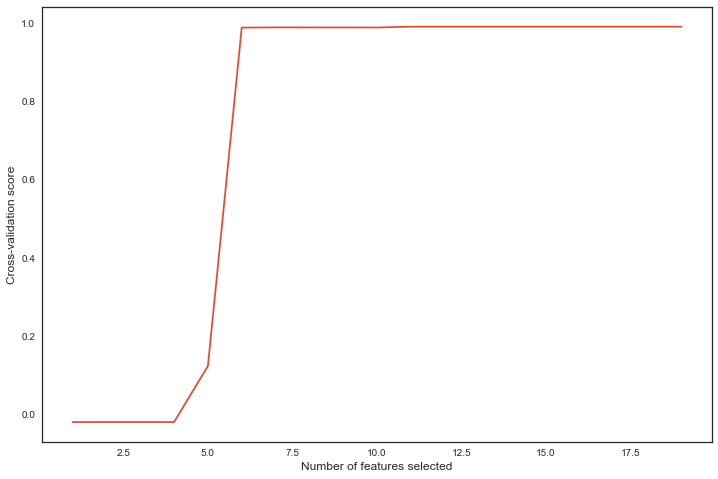

In [177]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation score')
plt.show()

# Select from model

<http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel>

In [184]:
lsvr = svm.LinearSVR(C=0.01, epsilon=0, dual=True).fit(X, y)
sfm = feature_selection.SelectFromModel(lsvr, prefit=True)

In [192]:
X.columns[sfm.get_support()]

Index(['FU', 'pin_pair', 'net'], dtype='object')

# Usage

In [102]:
def feature_ranking(X, y, kind='random_forest'):
    """Get feature importance for ranking and the optimal number of features.
    
    Notes
    -----
    `Random forest` leads to different feature importance than `Mutual info`.
    
    Scaling X or not does not affect the result.
    """
    # hyper-parameters for random forest
    param_dict_small = {
        'n_estimators': [3, 10, 30],
        'max_depth': [1, 3, 10],
        'max_features': [0.1, 0.3, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 10],
        'bootstrap': [True, False],
        'criterion': ['mse', 'mae'],
    }
    
    # get feature importance for ranking
    if kind == 'random_forest':
        # find the best random forest parameters for feature importance
        grid_search = model_selection.GridSearchCV(ensemble.RandomForestRegressor(random_state=42),
                                                   param_grid=param_dict_small, scoring='r2')
        grid_search.fit(X, y)
        feature_importance = grid_search.best_estimator_.feature_importances_
    elif kind == 'mutual_info':
        mi = feature_selection.mutual_info_regression(X, y, random_state=42)
        mi /= np.max(mi)
        feature_importance = mi
    else:
        raise Exception('Unsupported feature importance method.')
    rank = X.columns[np.argsort(feature_importance)[::-1]]
    rank = np.array(rank)
        
    # the optimal number of features
    rfecv = feature_selection.RFECV(estimator=ensemble.RandomForestRegressor(random_state=42), step=1,
                                cv=model_selection.ShuffleSplit(random_state=42), scoring='r2')
    rfecv.fit(X, y)
    n_features = rfecv.n_features_
    
    return n_features, rank

In [71]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [103]:
feature_ranking(X_scaled, y)

(6, array(['AREA', 'pin_pair', 'MUX', 'net', 'MISC', 'REG', 'FU', 'max',
        'ave', 'min', 'state', 'BlockMemoryBit', 'MEM', 'sim', 'DEC',
        'Pmax', 'Pmin', 'Pave', 'DSP'], dtype=object))

In [104]:
feature_ranking(X_scaled, y, kind='mutual_info')

C:\Users\sxl131830\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(6, array(['pin_pair', 'net', 'AREA', 'MUX', 'MISC', 'FU', 'REG', 'state',
        'ave', 'min', 'max', 'sim', 'Pmin', 'BlockMemoryBit', 'MEM', 'DEC',
        'Pmax', 'Pave', 'DSP'], dtype=object))